In [ ]:
#First we imported the necessary libraries.
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from collections import defaultdict, Counter

In [ ]:
# We then load the dataset from a JSON file which we uploaded already to our colab system
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

data = load_data('/content/penn-data.json')

In [ ]:
# As per the instructions we then split our data into 80% train and 20% test
np.random.seed(42)
np.random.shuffle(data)
split_idx = int(len(data) * 0.8)
train_data, test_data = data[:split_idx], data[split_idx:]

In [ ]:
# We then convert our loaded dataset to list of (word, tag) tuples to bring it to a suitable format
formatted_train_data = [[(word, tag) for word, tag in zip(sent[0].split(), sent[1])] for sent in train_data]
formatted_test_data = [[(word, tag) for word, tag in zip(sent[0].split(), sent[1])] for sent in test_data]
train_data = formatted_train_data
test_data = formatted_test_data

In [ ]:
# We then extract the words and tags and maintain their counts
all_tags = set(tag for sent in train_data for _, tag in sent)
tag_counts = Counter(tag for sent in train_data for _, tag in sent)
word_counts = Counter(word.lower() for sent in train_data for word, _ in sent)
default_tag = max(tag_counts, key=tag_counts.get)

In [ ]:
#First we define the function to compute transition probabilites for First Order HMM
def compute_transition_probs_first_order(train_data):
    transitions = defaultdict(lambda: defaultdict(int))
    for sent in train_data:
        prev_tag = '<s>'
        for _, tag in sent:
            transitions[prev_tag][tag] += 1
            prev_tag = tag
    return {tag: {t: count / sum(transitions[tag].values()) for t, count in transitions[tag].items()} for tag in transitions}

In [ ]:
#Next we define the function to compute transition probabilites for Second Order HMM
def compute_transition_probs_second_order(train_data):
    transitions = defaultdict(lambda: defaultdict(int))
    for sent in train_data:
        prev_tag1 = '<s>'
        prev_tag2 = '<s>'
        for _, tag in sent:
            transitions[(prev_tag1, prev_tag2)][tag] += 1
            prev_tag1, prev_tag2 = prev_tag2, tag
    return {tags: {t: count / sum(transitions[tags].values()) for t, count in transitions[tags].items()} for tags in transitions}

In [ ]:
# Next we define the emission probability function for First Order HMM with Word Dependency: P(word | tag, previous_word)
def compute_emission_probs_word_dependent(train_data):
    emissions = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    for sent in train_data:
        prev_word = '<s>'
        for word, tag in sent:
            emissions[tag][prev_word.lower()][word.lower()] += 1
            prev_word = word
    return {tag: {prev_word: {w: count / sum(emissions[tag][prev_word].values()) for w, count in emissions[tag][prev_word].items()} for prev_word in emissions[tag]} for tag in emissions}

In [ ]:
# Next we compute emission probabilities for the other two methodologies P(word | tag)
def compute_emission_probs(train_data):
    emissions = defaultdict(lambda: defaultdict(int))
    for sent in train_data:
        for word, tag in sent:
            emissions[tag][word.lower()] += 1
    return {tag: {w: count / sum(emissions[tag].values()) for w, count in emissions[tag].items()} for tag in emissions}

In [ ]:
#Next we compute the probabilities
transition_probs_first = compute_transition_probs_first_order(train_data)
transition_probs_second = compute_transition_probs_second_order(train_data)
emission_probs = compute_emission_probs(train_data)
emission_probs_word_dependent = compute_emission_probs_word_dependent(train_data)

In [ ]:
#Next we define the viterbi algo for the 1st Methodology
def viterbi_first_order(sentence, transition_probs, emission_probs, tag_counts, unk_tag=default_tag):
    n = len(sentence)
    states = list(tag_counts.keys())
    viterbi = [{}]
    backpointer = [{}]

    for tag in states:
        viterbi[0][tag] = transition_probs.get('<s>', {}).get(tag, 1e-6) * emission_probs.get(tag, {}).get(sentence[0].lower(), 1e-6)
        backpointer[0][tag] = None

    for t in range(1, n):
        viterbi.append({})
        backpointer.append({})
        for tag in states:
            max_prob, prev_best = max(
                (viterbi[t-1][prev_tag] * transition_probs.get(prev_tag, {}).get(tag, 1e-6) * emission_probs.get(tag, {}).get(sentence[t].lower(), 1e-6), prev_tag)
                for prev_tag in states
            )
            viterbi[t][tag] = max_prob
            backpointer[t][tag] = prev_best

    best_path = []
    best_final_tag = max(states, key=lambda tag: viterbi[-1][tag])
    best_path.append(best_final_tag)

    for t in range(n-1, 0, -1):
        best_path.insert(0, backpointer[t][best_path[0]])

    return best_path

In [ ]:
#Next we define the viterbi algo for the 2nd Methodology
def viterbi_second_order(sentence, transition_probs, emission_probs, tag_counts, unk_tag=default_tag):
    n = len(sentence)
    states = list(tag_counts.keys())
    viterbi = [{}]
    backpointer = [{}]

    for tag in states:
        viterbi[0][tag] = transition_probs.get(('<s>', '<s>'), {}).get(tag, 1e-6) * emission_probs.get(tag, {}).get(sentence[0].lower(), 1e-6)
        backpointer[0][tag] = None

    for t in range(1, n):
        viterbi.append({})
        backpointer.append({})
        for tag in states:
            max_prob, prev_best = max(
                (viterbi[t-1][prev_tag] * transition_probs.get((prev_prev_tag, prev_tag), {}).get(tag, 1e-6) * emission_probs.get(tag, {}).get(sentence[t].lower(), 1e-6), prev_tag)
                for prev_prev_tag in states for prev_tag in states
            )
            viterbi[t][tag] = max_prob
            backpointer[t][tag] = prev_best

    best_path = []
    best_final_tag = max(states, key=lambda tag: viterbi[-1][tag])
    best_path.append(best_final_tag)

    for t in range(n-1, 0, -1):
        best_path.insert(0, backpointer[t][best_path[0]])

    return best_path

In [ ]:
#Next we define the viterbi algo for the 3rd Methodology
def viterbi_word_dependent(sentence, transition_probs, emission_probs, tag_counts, unk_tag=default_tag):
    n = len(sentence)
    states = list(tag_counts.keys())
    viterbi = [{}]
    backpointer = [{}]

    for tag in states:
        viterbi[0][tag] = transition_probs.get('<s>', {}).get(tag, 1e-6) * emission_probs.get(tag, {}).get('<s>', {}).get(sentence[0].lower(), 1e-6)
        backpointer[0][tag] = None

    for t in range(1, n):
        viterbi.append({})
        backpointer.append({})
        for tag in states:
            max_prob, prev_best = max(
                (viterbi[t-1][prev_tag] * transition_probs.get(prev_tag, {}).get(tag, 1e-6) * emission_probs.get(tag, {}).get(sentence[t-1].lower(), {}).get(sentence[t].lower(), 1e-6), prev_tag)
                for prev_tag in states
            )
            viterbi[t][tag] = max_prob
            backpointer[t][tag] = prev_best

    best_path = []
    best_final_tag = max(states, key=lambda tag: viterbi[-1][tag])
    best_path.append(best_final_tag)

    for t in range(n-1, 0, -1):
        best_path.insert(0, backpointer[t][best_path[0]])

    return best_path

In [ ]:
#We define an evaluation function to find the accuracy metrics for our methodologies
def evaluate_model_with_tagwise(test_data, viterbi_func, transition_probs, emission_probs, tag_counts, collapsed=False):
    correct = 0
    total = 0
    tag_correct = defaultdict(int)
    tag_total = defaultdict(int)

    for sentence in test_data:
        words = [word for word, _ in sentence]
        true_tags = [tag for _, tag in sentence]
        predicted_tags = viterbi_func(words, transition_probs, emission_probs, tag_counts)

        min_len = min(len(predicted_tags), len(true_tags))

        for i in range(min_len):
            tag_total[true_tags[i]] += 1
            if predicted_tags[i] == true_tags[i]:
                correct += 1
                tag_correct[true_tags[i]] += 1
            total += 1

    overall_accuracy = correct / total if total > 0 else 0
    tagwise_accuracy = {tag: tag_correct[tag] / tag_total[tag] if tag_total[tag] > 0 else 0 for tag in tag_total}


    if collapsed:
        print(f"Overall Accuracy: {overall_accuracy:.4f}")
        print("\Tag-wise Accuracy:")
        for tag in ['N', 'V', 'A', 'O']:
            acc = tagwise_accuracy.get(tag, 0)
            print(f"{tag}: {acc:.4f}")
    else:
        print(f"Overall Accuracy: {overall_accuracy:.4f}")
        print("\nTag-wise Accuracy:")
        for tag, acc in sorted(tagwise_accuracy.items()):
            print(f"{tag}: {acc:.4f}")
    return overall_accuracy, tagwise_accuracy

In [ ]:
# Now we evaluate each model
print("Evaluating models...")
first_order_acc, first_order_tagwise = evaluate_model_with_tagwise(test_data, viterbi_first_order, transition_probs_first, emission_probs, tag_counts)
second_order_acc, second_order_tagwise = evaluate_model_with_tagwise(test_data, viterbi_second_order, transition_probs_second, emission_probs, tag_counts)
word_dep_acc, word_dep_tagwise = evaluate_model_with_tagwise(test_data, viterbi_word_dependent, transition_probs_first, emission_probs_word_dependent, tag_counts)

# Printing the results
print(f"First Order HMM Overall Accuracy with 36 tags: {first_order_acc:.4f}")
print("Tag-wise accuracy:")
for tag, acc in first_order_tagwise.items():
    print(f"{tag}: {acc:.4f}")

print(f"\nSecond Order HMM Overall Accuracy with 36 tags: {second_order_acc:.4f}")
print("Tag-wise accuracy:")
for tag, acc in second_order_tagwise.items():
    print(f"{tag}: {acc:.4f}")

print(f"\nWord Dependent HMM Overall Accuracy with 36 tags: {word_dep_acc:.4f}")
print("Tag-wise accuracy:")
for tag, acc in word_dep_tagwise.items():
    print(f"{tag}: {acc:.4f}")


Evaluating models...
Overall Accuracy: 0.8681

Tag-wise Accuracy:
#: 1.0000
'': 1.0000
,: 0.0000
-LRB-: 1.0000
-RRB-: 1.0000
:: 1.0000
CC: 0.9911
CD: 0.7643
DT: 0.9909
EX: 0.9474
IN: 0.9785
JJ: 0.8029
JJR: 0.8750
JJS: 0.7955
MD: 0.9951
NN: 0.8646
NNP: 0.7759
NNPS: 0.4464
NNS: 0.7837
PDT: 0.7500
PRP: 0.9801
PRP$: 1.0000
RB: 0.7854
RBR: 0.4615
RBS: 0.9000
RP: 0.8571
SYM: 0.0000
TO: 0.9976
VB: 0.9025
VBD: 0.8463
VBG: 0.6721
VBN: 0.7209
VBP: 0.7563
VBZ: 0.8845
WDT: 0.8444
WP: 0.9811
WP$: 1.0000
WRB: 0.9474
Overall Accuracy: 0.8407

Tag-wise Accuracy:
#: 1.0000
'': 0.6667
,: 0.0000
-LRB-: 0.8750
-RRB-: 1.0000
:: 1.0000
CC: 0.9911
CD: 0.7586
DT: 0.9861
EX: 0.9474
IN: 0.9599
JJ: 0.7652
JJR: 0.7778
JJS: 0.8409
MD: 0.9902
NN: 0.8024
NNP: 0.7077
NNPS: 0.3750
NNS: 0.8125
PDT: 0.5000
PRP: 0.9886
PRP$: 0.9928
RB: 0.8091
RBR: 0.5385
RBS: 0.8000
RP: 0.7619
SYM: 0.0000
TO: 0.9976
VB: 0.8129
VBD: 0.7872
VBG: 0.6590
VBN: 0.7302
VBP: 0.6738
VBZ: 0.9003
WDT: 0.8222
WP: 0.9623
WP$: 1.0000
WRB: 0.9474
Overa

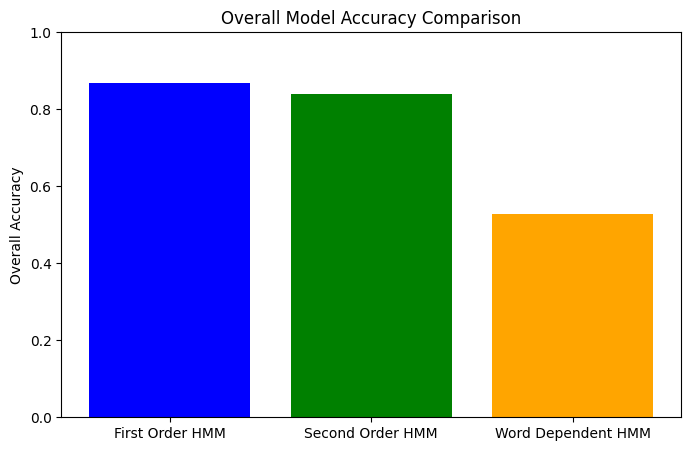

In [ ]:
# Model names
models = ["First Order HMM", "Second Order HMM", "Word Dependent HMM"]
accuracies = [first_order_acc, second_order_acc, word_dep_acc]

plt.figure(figsize=(8,5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.ylabel("Overall Accuracy")
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.title("Overall Model Accuracy Comparison")
plt.show()

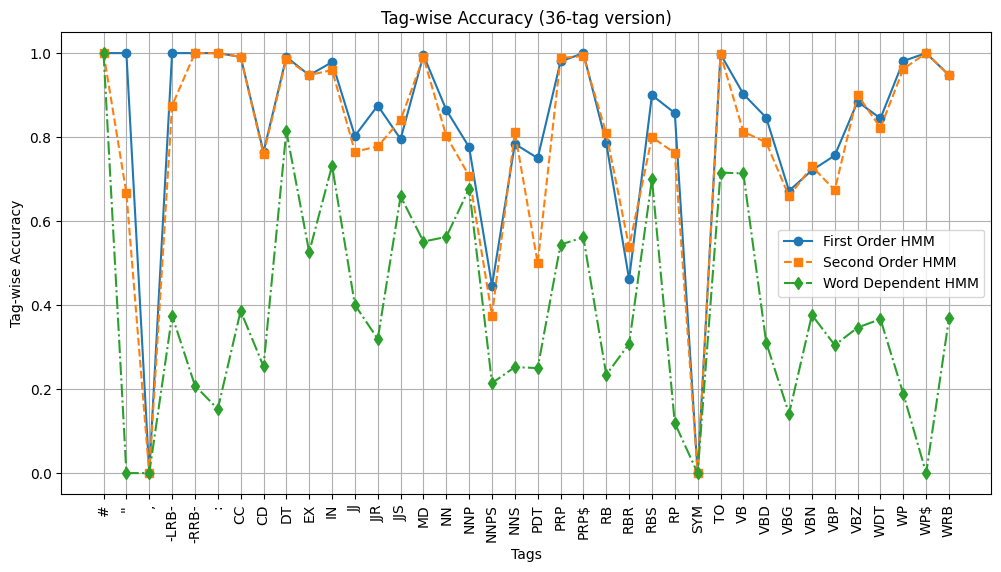

In [ ]:
# Assuming tagwise accuracy dictionaries for each model
tags = sorted(first_order_tagwise.keys())  # Sort for consistency
first_order_accs = [first_order_tagwise[tag] for tag in tags]
second_order_accs = [second_order_tagwise[tag] for tag in tags]
word_dep_accs = [word_dep_tagwise[tag] for tag in tags]

plt.figure(figsize=(12,6))
plt.plot(tags, first_order_accs, marker='o', linestyle='-', label="First Order HMM")
plt.plot(tags, second_order_accs, marker='s', linestyle='--', label="Second Order HMM")
plt.plot(tags, word_dep_accs, marker='d', linestyle='-.', label="Word Dependent HMM")

plt.xlabel("Tags")
plt.ylabel("Tag-wise Accuracy")
plt.xticks(rotation=90)
plt.title("Tag-wise Accuracy (36-tag version)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
#Now we do implementation for the collapsed tags part with 4tags instead of 36
collapsed_tags = {
    'N': {'NN', 'NNS', 'NNP', 'NNPS'},
    'V': {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'},
    'A': {'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'},
    'O': set()  # Will be updated after all_tags is known
}

# We update 'O' to include remaining tags after all_tags is defined
all_original_tags = set(tag for sent in train_data for _, tag in sent)
collapsed_tags['O'] = all_original_tags - (collapsed_tags['N'] | collapsed_tags['V'] | collapsed_tags['A'])
def get_collapsed_tag(tag):
    for key, values in collapsed_tags.items():
        if tag in values:
            return key
    return 'O'  # Fallback

In [ ]:
# We then convert dataset to collapsed tags
formatted_train_data = [[(word, get_collapsed_tag(tag)) for word, tag in sent] for sent in train_data]
formatted_test_data = [[(word, get_collapsed_tag(tag)) for word, tag in sent] for sent in test_data]

train_data = formatted_train_data
test_data = formatted_test_data

In [ ]:
# We then extract collapsed tags and words and keep a count
all_tags = set(tag for sent in train_data for _, tag in sent)
tag_counts = Counter(tag for sent in train_data for _, tag in sent)
word_counts = Counter(word.lower() for sent in train_data for word, _ in sent)
default_tag = max(tag_counts, key=tag_counts.get)  # Most frequent tag

In [ ]:
# We then compute the probabilities
transition_probs_first = compute_transition_probs_first_order(train_data)
transition_probs_second = compute_transition_probs_second_order(train_data)
emission_probs = compute_emission_probs(train_data)
emission_probs_word_dependent = compute_emission_probs_word_dependent(train_data)

In [ ]:
#Now we find the metrics to judge our model performance and print those
print("First Order HMM:")
first_order_acc, first_order_tagwise = evaluate_model_with_tagwise(
    test_data, viterbi_first_order, transition_probs_first, emission_probs, tag_counts
)

print("\nSecond Order HMM:")
second_order_acc, second_order_tagwise = evaluate_model_with_tagwise(
    test_data, viterbi_second_order, transition_probs_second, emission_probs, tag_counts
)

print("\nWord Dependent HMM:")
word_dep_acc, word_dep_tagwise = evaluate_model_with_tagwise(
    test_data, viterbi_word_dependent, transition_probs_first, emission_probs_word_dependent, tag_counts
)


First Order HMM:
Overall Accuracy: 0.8954

Tag-wise Accuracy:
A: 0.7607
N: 0.8926
O: 0.9719
V: 0.8040

Second Order HMM:
Overall Accuracy: 0.8954

Tag-wise Accuracy:
A: 0.7652
N: 0.8904
O: 0.9717
V: 0.8060

Word Dependent HMM:
Overall Accuracy: 0.6139

Tag-wise Accuracy:
A: 0.3176
N: 0.7118
O: 0.7249
V: 0.3232


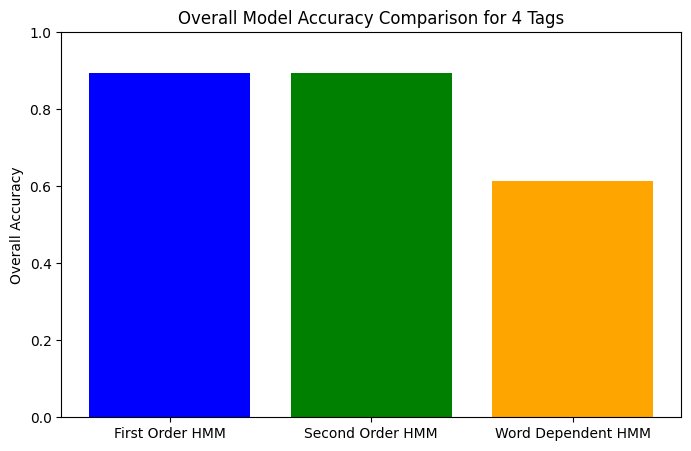

In [ ]:
# Model names
models = ["First Order HMM", "Second Order HMM", "Word Dependent HMM"]
accuracies = [first_order_acc, second_order_acc, word_dep_acc]

plt.figure(figsize=(8,5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.ylabel("Overall Accuracy")
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.title("Overall Model Accuracy Comparison for 4 Tags")
plt.show()


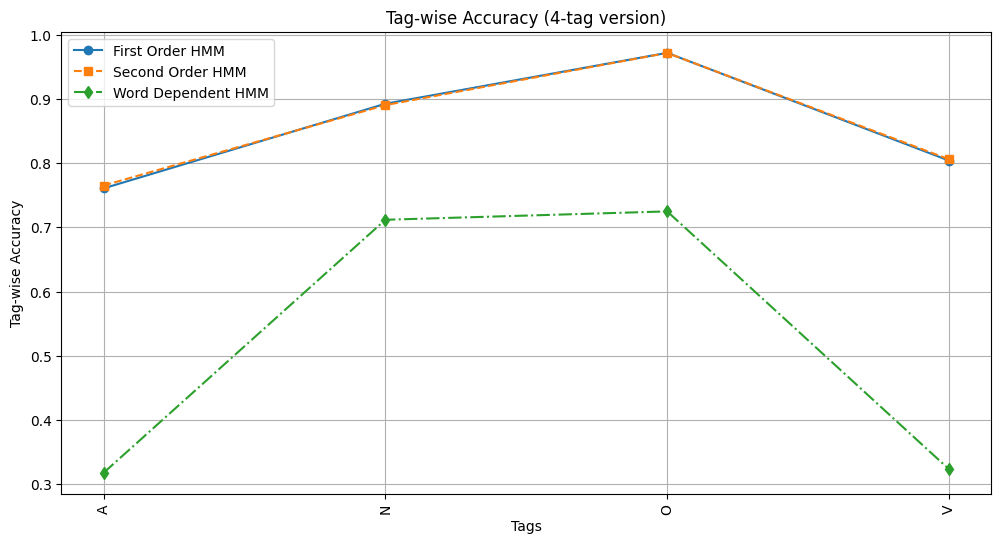

In [ ]:
# Assuming tagwise accuracy dictionaries for each model
tags = sorted(first_order_tagwise.keys())  # Sort for consistency
first_order_accs = [first_order_tagwise[tag] for tag in tags]
second_order_accs = [second_order_tagwise[tag] for tag in tags]
word_dep_accs = [word_dep_tagwise[tag] for tag in tags]

plt.figure(figsize=(12,6))
plt.plot(tags, first_order_accs, marker='o', linestyle='-', label="First Order HMM")
plt.plot(tags, second_order_accs, marker='s', linestyle='--', label="Second Order HMM")
plt.plot(tags, word_dep_accs, marker='d', linestyle='-.', label="Word Dependent HMM")

plt.xlabel("Tags")
plt.ylabel("Tag-wise Accuracy")
plt.xticks(rotation=90)
plt.title("Tag-wise Accuracy (4-tag version)")
plt.legend()
plt.grid()
plt.show()
